In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.0.0-rc0


In [3]:
tf.test.is_gpu_available()

True

In [4]:
keras = tf.keras
layers = tf.keras.layers

In [5]:
train_image_path = glob.glob('./dc/train/*/*.jpg')

In [6]:
len(train_image_path)

2000

In [7]:
train_image_path[-5:]

['./dc/train\\dog\\dog.995.jpg',
 './dc/train\\dog\\dog.996.jpg',
 './dc/train\\dog\\dog.997.jpg',
 './dc/train\\dog\\dog.998.jpg',
 './dc/train\\dog\\dog.999.jpg']

In [8]:
train_image_label = [int(p.split('\\')[1] == 'cat') for p in train_image_path]

In [9]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [10]:
train_image_label[ :5]

[1, 1, 1, 1, 1]

In [11]:
def load_preprosess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255
    return image, label

In [12]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
train_image_ds = train_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [15]:
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

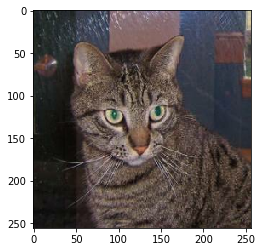

In [16]:
for img, label in train_image_ds.take(2):
    plt.imshow(img)

In [17]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [18]:
train_image_ds = train_image_ds.shuffle(train_count).repeat().batch(BATCH_SIZE)

In [19]:
test_image_path = glob.glob('./dc/test/*/*.jpg')
test_image_label = [int(p.split('\\')[1] == 'cat') for p in test_image_path]
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)

In [20]:
test_count = len(test_image_path)
test_count

1000

keras内置经典网络实现

In [21]:
covn_base = keras.applications.xception.Xception(weights='imagenet', 
                                                 include_top=False,
                                                 input_shape=(256, 256, 3),
                                                 pooling='avg')

In [22]:
covn_base.trainable = False

In [23]:
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [24]:
model = keras.Sequential()
model.add(covn_base)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [27]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['acc'])

In [35]:
initial_epochs = 5

In [29]:
history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Train for 62 steps, validate for 31 steps
Epoch 1/10


W0914 23:37:56.575596 11528 deprecation.py:323] From c:\users\guanghua\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


62/62 [==============================] - 107s 2s/step - loss: 0.1681 - acc: 0.9390 - val_loss: 0.3308 - val_acc: 0.8881
Epoch 2/10
62/62 [==============================] - 99s 2s/step - loss: 0.0800 - acc: 0.9753 - val_loss: 0.0709 - val_acc: 0.9738
Epoch 3/10
62/62 [==============================] - 114s 2s/step - loss: 0.0530 - acc: 0.9824 - val_loss: 0.2589 - val_acc: 0.9304
Epoch 4/10
62/62 [==============================] - 116s 2s/step - loss: 0.0740 - acc: 0.9758 - val_loss: 0.2762 - val_acc: 0.9264
Epoch 5/10
62/62 [==============================] - 116s 2s/step - loss: 0.0539 - acc: 0.9819 - val_loss: 0.0815 - val_acc: 0.9708
Epoch 6/10
 9/62 [===>..........................] - ETA: 1:24 - loss: 0.0297 - acc: 0.9844

KeyboardInterrupt: 

In [30]:
covn_base.trainable = True

In [31]:
len(covn_base.layers)

133

In [32]:
fine_tune_at = -33

In [33]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable =  False

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.0005/10),
              metrics=['accuracy'])

In [36]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs


history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch = initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE)

Train for 62 steps, validate for 31 steps
Epoch 6/10
62/62 [==============================] - 146s 2s/step - loss: 0.0206 - accuracy: 0.9914 - val_loss: 0.0361 - val_accuracy: 0.9879
Epoch 7/10
62/62 [==============================] - 146s 2s/step - loss: 0.0141 - accuracy: 0.9934 - val_loss: 0.0384 - val_accuracy: 0.9879
Epoch 8/10
62/62 [==============================] - 145s 2s/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.0543 - val_accuracy: 0.9788
Epoch 9/10
62/62 [==============================] - 145s 2s/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0319 - val_accuracy: 0.9909
Epoch 10/10
62/62 [==============================] - 145s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 0.9889
